In [1]:
!pip install -qq gdown
!pip install -qq torchinfo

In [1]:
import os
import requests
import gdown
from zipfile import ZipFile

from PIL import Image
import numpy as np

from torchinfo import summary

import torch
import torchvision.transforms as T

import torchvision.transforms.functional as F

import matplotlib.pyplot as plt
import time

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
ISNET_MODEL_URL = "https://drive.google.com/uc?id=1XHIzgTzY5BQHw140EDIgwIb53K659ENH"
ISNET_MODEL_PATH = "isnet-general-use.pth"

if not os.path.exists(os.path.join(os.getcwd(), ISNET_MODEL_PATH)):
    _ = gdown.download(ISNET_MODEL_URL, ISNET_MODEL_PATH)

Downloading...
From (original): https://drive.google.com/uc?id=1XHIzgTzY5BQHw140EDIgwIb53K659ENH
From (redirected): https://drive.google.com/uc?id=1XHIzgTzY5BQHw140EDIgwIb53K659ENH&confirm=t&uuid=85552b67-443c-4f22-b96c-e2c18f457179
To: /content/isnet-general-use.pth
100%|██████████| 177M/177M [00:04<00:00, 40.5MB/s]


In [6]:
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    # print(file.status_code)
    open(save_path, "wb").write(file.content)

    try:
        # Extract zipfile.
        if save_path.endswith(".zip"):
            with ZipFile(save_path) as zip:
                zip.extractall(os.path.split(save_path)[0])

        print("Done")
    except:
        print("Invalid file")

TEST_IMAGE_DIR = "test_images"
TEST_DIR_ZIP = TEST_IMAGE_DIR+".zip"
IMAGE_DATA_URL = "https://www.dropbox.com/scl/fi/266ke2me03xgt74vdrb4x/test_images.zip?rlkey=ipul6odyiw596up1bf24dgnky&st=8a04ypoc&dl=1"

SCRIPTS_URL = "https://www.dropbox.com/scl/fo/bsqlkbvnajghhoeljf7kw/APphPibd3WjoeMHZ0IO6Q_Y?rlkey=0nqlamncqg1x0tv6hyd5unj3h&st=cq4012mz&dl=1"
SCRIPTS_ZIP = "scripts.zip"

if not os.path.exists(os.path.join(os.getcwd(), "test_images")):
    download_and_unzip(IMAGE_DATA_URL, TEST_DIR_ZIP)
    os.remove(TEST_DIR_ZIP)

if not os.path.exists(os.path.join(os.getcwd(), "u2net.py")):
    download_and_unzip(SCRIPTS_URL, SCRIPTS_ZIP)
    os.remove(SCRIPTS_ZIP)

In [2]:
from isnet import ISNetDIS
isnet = ISNetDIS(in_ch=3,out_ch=1)

ISNET_MODEL_PATH = "isnet-general-use.pth"
TEST_IMAGE_DIR="/content/test_images"

def load_model(model, model_path, device):

    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)

    return model

def denorm_image(image, mean, std):
    image_denorm = torch.addcmul(mean[:,None,None], image, std[:,None, None])
    image = torch.clamp(image_denorm*255., min=0., max=255.)
    image = torch.permute(image, dims=(1,2,0)).numpy().astype("uint8")

    return image

def prepare_image_batch(image_dir, resize, transforms, device):

    image_batch = []

    for image_file in os.listdir(image_dir):
        image = Image.open(os.path.join(image_dir, image_file)).convert("RGB")
        image_resize = image.resize(resize, resample = Image.BILINEAR)

        image_trans = transforms(image_resize)
        image_batch.append(image_trans)


    image_batch = torch.stack(image_batch).to(device)

    return image_batch



isnet = load_model(model=isnet, model_path=ISNET_MODEL_PATH, device=device)
MEAN = torch.tensor([0.5, 0.5, 0.5])
STD = torch.tensor([1.0, 1.0, 1.0])

resize_shape = (256,256)#1024,1024

transforms = T.Compose([T.ToTensor(),
                        T.Normalize(mean=MEAN, std=STD)])

image_batch = prepare_image_batch(image_dir=TEST_IMAGE_DIR,
                                 resize=resize_shape,
                                 transforms=transforms,
                                 device=device)

In [3]:
def prepare_predictions(model, image_batch):

    model.eval()

    all_results = []

    for image in image_batch:
        with torch.no_grad():
            results = model(image.unsqueeze(dim=0))

        all_results.append(torch.squeeze(results[0][0].cpu(), dim=(0,1)).numpy())

    return all_results

def normPRED(predicted_map):
    ma = np.max(predicted_map)
    mi = np.min(predicted_map)

    map_normalize = (predicted_map - mi) / (ma-mi)

    return map_normalize

predictions_isnet = prepare_predictions(isnet, image_batch)

**Test**

In [6]:
resize= (256,256)#1024,1024
image = Image.open('/content/test_W1.png').convert("RGB")
image_resize = image.resize(resize, resample = Image.BILINEAR)

start_time = time.perf_counter()
image_trans = transforms(image_resize).to(device)
predictions_isnet = prepare_predictions(isnet, image_trans.unsqueeze(dim=0))
pred_normalize = normPRED(predictions_isnet)
pred_final = np.clip(pred_normalize*255., a_min=0, a_max=255.).astype("uint8")
end_time = time.perf_counter()
print(
    f" Processing Time: {(end_time-start_time)*1000:.2f} ms, "
    f"FPS: {1/(end_time-start_time):.2f}."
)

 Processing Time: 29.44 ms, FPS: 33.97.


(-0.5, 255.5, 255.5, -0.5)

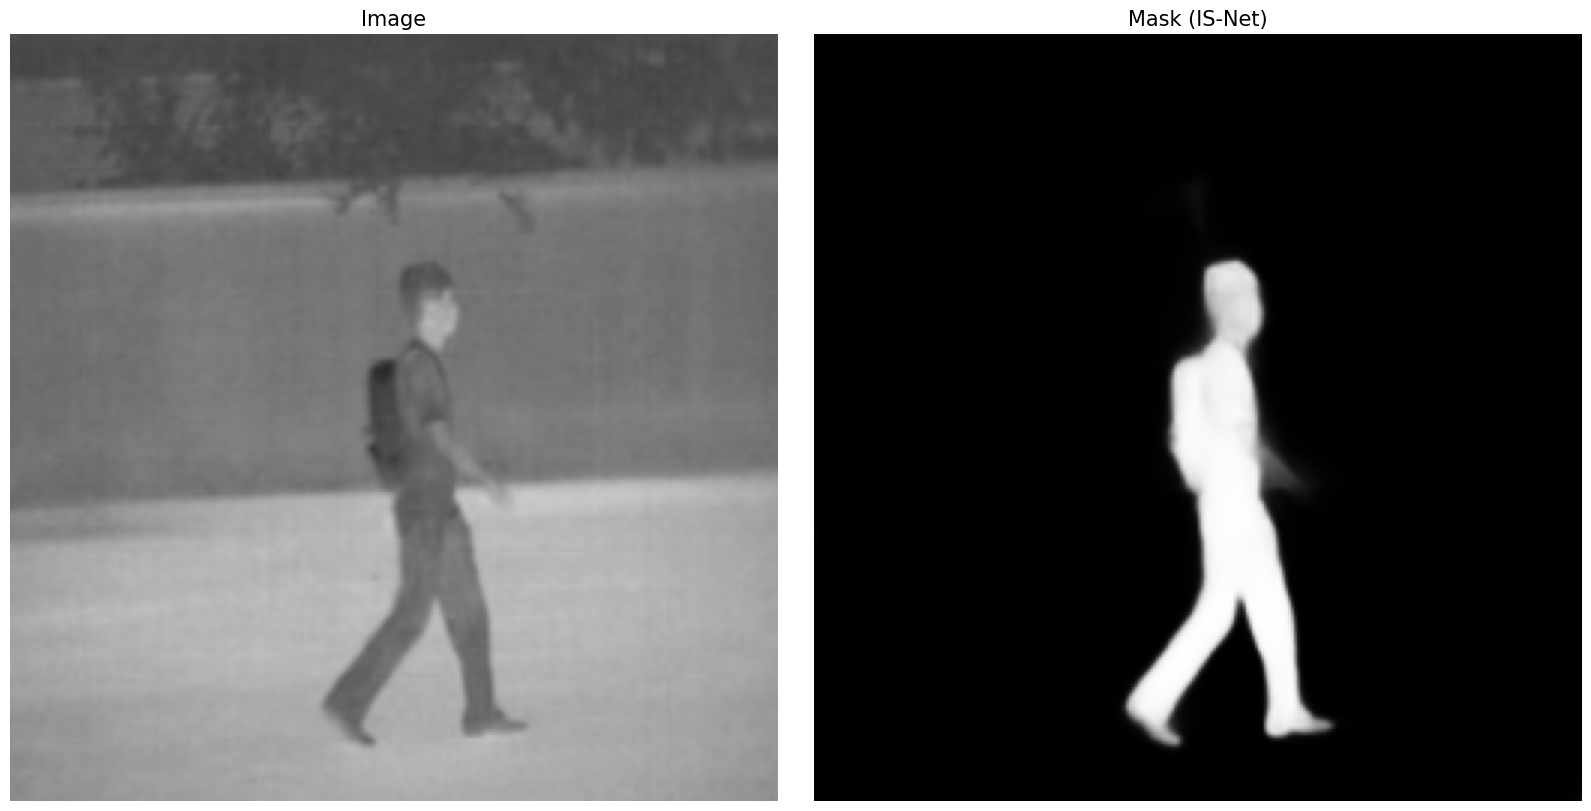

In [7]:
plt.figure(figsize=(16,8), layout="constrained")

plt.subplot(1,2,1)
plt.imshow(image_resize)
plt.title("Image", fontsize=15)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(pred_final[0], cmap="gray")
plt.title("Mask (IS-Net)", fontsize=15)
plt.axis("off")